In [1]:
import random,datetime

In [2]:
class Position:
    def __init__(self, x, y):
        self.X = x
        self.Y = y

    def __str__(self):
        return "{},{}".format(self.X, self.Y)

    def __eq__(self, other):
        return self.X == other.X and self.Y == other.Y

    def __hash__(self):
        return self.X * 1000 + self.Y

class Board:
    def __init__(self, positions, width, height):
        board = [['.'] * width for _ in range(height)]

        for index in range(len(positions)):
            knightPosition = positions[index]
            board[knightPosition.Y][knightPosition.X] = 'N'
        self._board = board
        self._width = width
        self._height = height

    def print(self):
        # 0,0 prints in bottom left corner
        for i in reversed(range(self._height)):
            print(i, "\t", ' '.join(self._board[i]))
        print(" \t", ' '.join(map(str, range(self._width))))

In [3]:
def get_attacks(location, boardWidth, boardHeight):
    return [i for i in set(
        Position(x + location.X, y + location.Y)
        for x in [-2, -1, 1, 2] if 0 <= x + location.X < boardWidth
        for y in [-2, -1, 1, 2] if 0 <= y + location.Y < boardHeight
        and abs(y) != abs(x))]

In [4]:
n = get_attacks(Position(0,0),8,8)
Board(n,8,8).print()

7 	 . . . . . . . .
6 	 . . . . . . . .
5 	 . . . . . . . .
4 	 . . . . . . . .
3 	 . . . . . . . .
2 	 . N . . . . . .
1 	 . . N . . . . .
0 	 . . . . . . . .
 	 0 1 2 3 4 5 6 7


In [5]:
n = get_attacks(Position(3,4),8,8)
Board(n,8,8).print()

7 	 . . . . . . . .
6 	 . . N . N . . .
5 	 . N . . . N . .
4 	 . . . . . . . .
3 	 . N . . . N . .
2 	 . . N . N . . .
1 	 . . . . . . . .
0 	 . . . . . . . .
 	 0 1 2 3 4 5 6 7


In [6]:
def get_fitness(genes, boardWidth, boardHeight):
    attacked = set(pos
                   for kn in genes
                   for pos in get_attacks(kn, boardWidth, boardHeight))
    return len(attacked)

In [7]:
def display(candidate, startTime, boardWidth, boardHeight):
    timeDiff = datetime.datetime.now() - startTime
    board = Board(candidate.Genes, boardWidth, boardHeight)
    board.print()

    print("{}\n\t{}\t{}".format(
        ' '.join(map(str, candidate.Genes)),
        candidate.Fitness,
        timeDiff))

In [8]:
def mutate(genes, boardWidth, boardHeight, allPositions, nonEdgePositions):
    #随机交换8-10组基因，这个值也可以修改，一般来说，别太多，否则慢。
    for i in range(random.randint(8,10)):
        #构建一个由棋盘上所有的点所组成的字典
        positionToKnightIndexes = dict((p, []) for p in allPositions)
        #从种群的基因库中查看骑士的位置，然后把这些骑士能够攻击到的点，都加入到上面那个字典里面
        # 结构是{点1:[骑士1的索引,骑士2的索引]……}
        for i, knight in enumerate(genes):
            for position in get_attacks(knight, boardWidth, boardHeight):
                positionToKnightIndexes[position].append(i)
        knightIndexes = set(i for i in range(len(genes)))
        unattacked = []
        #下面对每个点进行进行迭代，如果某个点没有任何一个骑士可以攻击到的话，把这个点记录下面
        # 如果某个点，只有一个骑士可以攻击到，那个这个骑士的位置就太浪费
        # 会把这个骑士先移除掉，设定为需要重新放位的
        for kvp in positionToKnightIndexes.items():
            if len(kvp[1]) > 1:
                continue
            if len(kvp[1]) == 0:
                unattacked.append(kvp[0])
                continue
            for p in kvp[1]:  # len == 1
                if p in knightIndexes:
                    knightIndexes.remove(p)
        
        # 对于完全没有被攻击到的点，进行一次计算，计算出可以攻击到他们的位置
        # 也就是潜在的要被攻击的点。
        # 而且这些潜在的点，需要是非边界上的点。
        # 如果未被攻击到的点小于等于0了，那么需要计算的潜在点，就是非边界点。
        potentialKnightPositions = \
            [p for positions in
             map(lambda x: get_attacks(x, boardWidth, boardHeight),
                 unattacked)
             for p in positions if p in nonEdgePositions] \
                if len(unattacked) > 0 else nonEdgePositions
        
        #选择需要替换的基因库里面的基因
        geneIndex = random.randrange(0, len(genes)) \
            if len(knightIndexes) == 0 \
            else random.choice([i for i in knightIndexes])
        # 在前致电里面，选择一个位置，设置为新的骑士的位置
        position = random.choice(potentialKnightPositions)
        genes[geneIndex] = position
        return Chromosome(genes, get_fitness(genes,boardWidth, boardHeight))

In [9]:
def fnGetRandomPosition():
    return random.choice(nonEdgePositions)

def create(fnGetRandomPosition, expectedKnights):
    genes = [fnGetRandomPosition() for _ in range(expectedKnights)]
    return genes

In [10]:
class Chromosome:
    def __init__(self, genes, fitness):
        self.Genes = genes
        self.Fitness = fitness

In [17]:
boardHeight = 8
boardWidth = 8
expectedKnights = 14

In [12]:
boardHeight = 10
boardWidth = 10
expectedKnights = 22

In [18]:
allPositions = [Position(x, y)
                        for y in range(boardHeight)
                        for x in range(boardWidth)]
nonEdgePositions = [i for i in allPositions
                            if 0 < i.X < boardWidth - 1 and
                            0 < i.Y < boardHeight - 1]

In [21]:
def get_best():
    startTime = datetime.datetime.now()
    optimalFitness = boardWidth * boardHeight
    geneset = create(fnGetRandomPosition,expectedKnights)
    best = Chromosome(geneset, get_fitness(geneset,boardHeight,boardWidth))
    if best.Fitness == optimalFitness:
        return best
    num = 0
    while True:
        child = mutate(best.Genes, boardWidth, boardHeight, 
                       allPositions, nonEdgePositions)
        num +=1
        if best.Fitness > child.Fitness:
            continue
        #display(child,startTime, boardWidth, boardHeight)
        if not child.Fitness > best.Fitness:
            best = child
        if child.Fitness == optimalFitness:
            break
        best = child
    return (best,num)

In [20]:
get_best()[1]

7 	 . . . . . . . .
6 	 . . . . . . . .
5 	 . . N N N . . .
4 	 . . . N . N . .
3 	 . . N . N . . .
2 	 . N N . N . . .
1 	 . . . N . . N .
0 	 . . . . . . . .
 	 0 1 2 3 4 5 6 7
2,3 4,2 3,4 2,2 4,5 3,5 4,5 2,5 6,1 4,3 5,4 1,2 3,1 4,5
	49	0:00:00.001996
7 	 . . . . . . . .
6 	 . . . . . . . .
5 	 . . N N N N . .
4 	 . . . . . N . .
3 	 . . N . N . . .
2 	 . N N . N . . .
1 	 . . . N . . N .
0 	 . . . . . . . .
 	 0 1 2 3 4 5 6 7
2,3 4,2 5,5 2,2 4,5 3,5 4,5 2,5 6,1 4,3 5,4 1,2 3,1 4,5
	53	0:00:00.004985
7 	 . . . . . . . .
6 	 . . . . . . . .
5 	 . . N N N N . .
4 	 . . N . . N . .
3 	 . . N . N . . .
2 	 . N N . N . . .
1 	 . . . N . . N .
0 	 . . . . . . . .
 	 0 1 2 3 4 5 6 7
2,3 4,2 5,5 2,2 4,5 3,5 4,5 2,5 6,1 4,3 5,4 1,2 3,1 2,4
	56	0:00:00.007979
7 	 . . . . . . . .
6 	 . . . . N . . .
5 	 . . N N N N . .
4 	 . . N . . N . .
3 	 . . N . N . . .
2 	 . N N . N . . .
1 	 . . . N . . N .
0 	 . . . . . . . .
 	 0 1 2 3 4 5 6 7
2,3 4,2 5,5 2,2 4,6 3,5 4,5 2,5 6,1 4,3 5,4 1,2 3,1 2,4
	58

970

In [22]:
n = []
for i in range(100):
    n.append(get_best()[1])

In [23]:
import matplotlib.pyplot as plt
import numpy

(array([26., 30., 18., 11.,  3.,  4.,  3.,  4.,  0.,  1.]),
 array([  15.,  246.,  477.,  708.,  939., 1170., 1401., 1632., 1863.,
        2094., 2325.]),
 <a list of 10 Patch objects>)

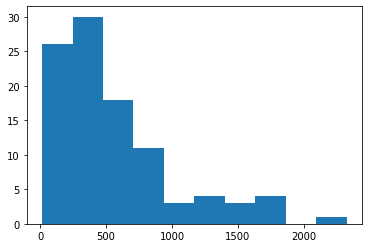

In [24]:
plt.hist(n)

In [25]:
numpy.mean(n)

543.12